In [23]:
import os
import pathlib
import csv
import datetime
import pandas as pd
import numpy as np

# Function to generate Laplace noise for categorical data
def laplace_mechanism_categorical(epsilon, sensitivity):
    beta = sensitivity / epsilon
    return np.random.laplace(0, beta, 1)[0]

# Function to add Laplace noise to counts for categorical data
def add_noise_categorical(counts, epsilon):
    noisy_counts = {}
    for category, count in counts.items():
        noisy_count = count + laplace_mechanism_categorical(epsilon, 1)
        noisy_counts[category] = noisy_count
    return noisy_counts

def deviceByWeekDP(epsilon):
    print("DevicebyweekDP")
    currentDir = os.getcwd()
    currentDir = currentDir + '/drive/MyDrive'
    pathlib.Path(currentDir + '/tmp/Device').mkdir(parents=True, exist_ok=True)
    startDate = None

    with open(currentDir + '/r1/device.csv') as deviceFile:
        weekStart = None
        currentCounts = {}
        lineCount = 0
        for row in csv.reader(deviceFile, delimiter=','):
            if lineCount == 0:
                print("Processing file:", deviceFile)
                lineCount += 1
                continue
            date = datetime.datetime.strptime(row[1], '%m/%d/%Y %H:%M:%S')
            if weekStart is None:
                weekStart = date
                startDate = date
            while (date.date() - weekStart.date()).days >= 7:
                tmpFileName = currentDir + '/tmp/Device/' + weekStart.strftime("%m-%d-%Y") + '.csv'
                f = open(tmpFileName, "w+")
                f.close()
                # Add Laplace noise to counts
                noisy_counts = add_noise_categorical(currentCounts, epsilon)
                df = pd.DataFrame.from_dict(noisy_counts, orient='index', columns=['count'])
                df.index.name = 'user'
                df.reset_index(inplace=True)
                df.to_csv(tmpFileName, sep=',', index=False)
                currentCounts = {}
                weekStart += datetime.timedelta(days=7)
            user = row[2]
            currentCounts[user] = currentCounts.get(user, 0) + 1
    return startDate

def logonByWeekDP(startDate, epsilon):
    print("LogonbyweekDP")
    currentDir = os.getcwd()
    currentDir = currentDir + '/drive/MyDrive'
    pathlib.Path(currentDir + '/tmp/Logon').mkdir(parents=True, exist_ok=True)

    with open(currentDir + '/r1/logon.csv') as logonFile:
        weekStart = startDate
        currentCounts = {}
        lineCount = 0
        for row in csv.reader(logonFile, delimiter=','):
            if lineCount == 0:
                print("Processing file:", logonFile)
                lineCount += 1
                continue
            date = datetime.datetime.strptime(row[1], '%m/%d/%Y %H:%M:%S')
            while (date.date() - weekStart.date()).days >= 7:
                tmpFileName = currentDir + '/tmp/Logon/' + weekStart.strftime("%m-%d-%Y") + '.csv'
                f = open(tmpFileName, "w+")
                f.close()
                # Add Laplace noise to counts
                noisy_counts = add_noise_categorical(currentCounts, epsilon)
                df = pd.DataFrame.from_dict(noisy_counts, orient='index', columns=['count'])
                df.index.name = 'user'
                df.reset_index(inplace=True)
                df.to_csv(tmpFileName, sep=',', index=False)
                currentCounts = {}
                weekStart += datetime.timedelta(days=7)
            user = row[2]
            currentCounts[user] = currentCounts.get(user, 0) + 1

def httpByWeekDP(startDate, epsilon):
    print("HttpbyWeekDP")
    currentDir = os.getcwd()
    currentDir = currentDir + '/drive/MyDrive'
    pathlib.Path(currentDir + '/tmp/Http').mkdir(parents=True, exist_ok=True)

    with open(currentDir + '/r1/http.csv') as httpFile:
        weekStart = startDate
        currentCounts = {}
        lineCount = 0
        for row in csv.reader(httpFile, delimiter=','):
            date = datetime.datetime.strptime(row[1], '%m/%d/%Y %H:%M:%S')
            while (date.date() - weekStart.date()).days >= 7:
                tmpFileName = currentDir + '/tmp/Http/' + weekStart.strftime("%m-%d-%Y") + '.csv'
                f = open(tmpFileName, "w+")
                f.close()
                # Add Laplace noise to counts
                noisy_counts = add_noise_categorical(currentCounts, epsilon)
                df = pd.DataFrame.from_dict(noisy_counts, orient='index', columns=['count'])
                df.index.name = 'user'
                df.reset_index(inplace=True)
                df.to_csv(tmpFileName, sep=',', index=False)
                currentCounts = {}
                weekStart += datetime.timedelta(days=7)
            user = row[2]
            currentCounts[user] = currentCounts.get(user, 0) + 1

def outputData(epsilon):
    currentDir = os.getcwd()

    dataDir = currentDir + '/drive/MyDrive/r1'

    print("Expecting data in directory", dataDir)

    startDate = deviceByWeekDP(epsilon)
    if startDate is None:
        print("Error: Did not find any device data")
        return
    logonByWeekDP(startDate,epsilon)
    httpByWeekDP(startDate,epsilon)

    employees = {} # map user -> (employee name, email, role) where user = domain || '/' ||user_id
    LDAPDir = dataDir + '/LDAP'
    ldapFiles = sorted(os.listdir(LDAPDir))
    for ladpFilename in ldapFiles:
        with open(LDAPDir + '/' + ladpFilename) as ldapFile:
            ldapReader = csv.reader(ldapFile, delimiter=',')
            lineCount = 0
            for row in ldapReader:
                if lineCount == 0:
                    print("Processing file:", ladpFilename)
                    lineCount += 1
                else:
                    domain = row[2][:-4].upper()
                    user = domain + '/' + row[1]

                    if user in employees and (employees[user][0] != row[0] or employees[user][1] != row[3] or employees[user][2] != row[4]):
                        print("Contrasting entries: had", employees[user], "for user", user, "but got", (row[0], row[3], row[4]))
                    employees[user] = (row[0], row[3], row[4])
                    lineCount += 1


    print("done")




if __name__ == "__main__":
    epsilon = 0.5
    outputData(epsilon)



Expecting data in directory /content/drive/MyDrive/r1
DevicebyweekDP
Processing file: <_io.TextIOWrapper name='/content/drive/MyDrive/r1/device.csv' mode='r' encoding='UTF-8'>
LogonbyweekDP
Processing file: <_io.TextIOWrapper name='/content/drive/MyDrive/r1/logon.csv' mode='r' encoding='UTF-8'>
HttpbyWeekDP
Processing file: 2009-12.csv
Processing file: 2010-01.csv
Processing file: 2010-02.csv
Processing file: 2010-03.csv
Processing file: 2010-04.csv
Processing file: 2010-05.csv
Processing file: 2010-06.csv
Processing file: 2010-07.csv
Processing file: 2010-08.csv
Processing file: 2010-09.csv
Processing file: 2010-10.csv
Processing file: 2010-11.csv
Processing file: 2010-12.csv
Processing file: 2011-01.csv
Processing file: 2011-02.csv
Processing file: 2011-03.csv
Processing file: 2011-04.csv
Processing file: 2011-05.csv
done


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


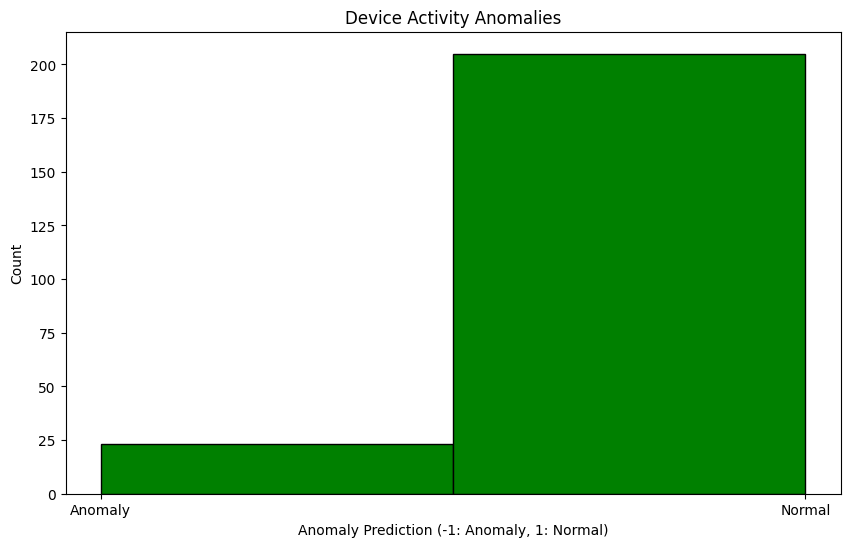

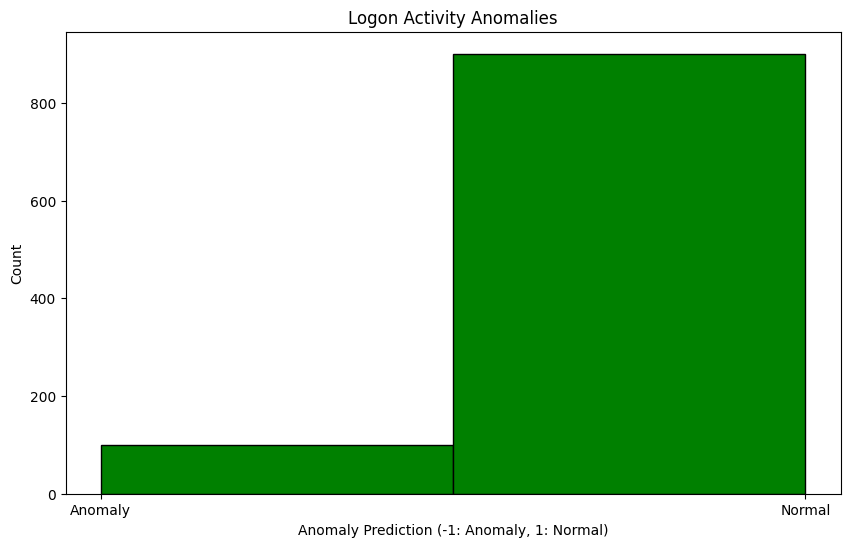

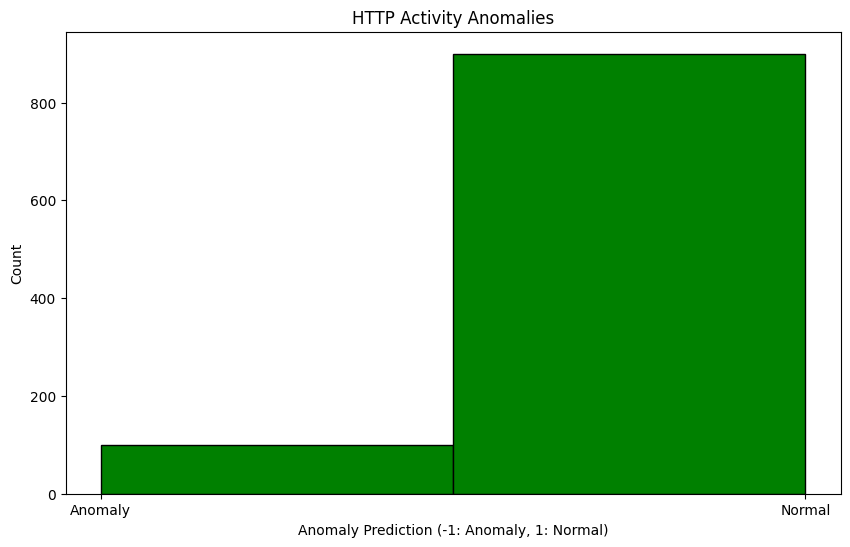

In [25]:
import os
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

def aggregate_data(directory):
    all_data = pd.DataFrame()

    # Iterate through each file in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            # Read data from CSV file
            data = pd.read_csv(file_path)
            # Concatenate data to the overall dataframe
            all_data = pd.concat([all_data, data])

    # Group by user and sum the counts
    aggregated_data = all_data.groupby('user').sum()

    return aggregated_data

def fit_isolation_forest(data):
    # Fit Isolation Forest
    isolation_forest = IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
                         max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
                         verbose=0)
    isolation_forest.fit(data)

    # Predict anomalies
    predictions = isolation_forest.predict(data)

    return predictions

def plot_anomalous_users(predictions, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.hist(predictions, bins=[-1, 0, 1], color=['green'], edgecolor='black')
    plt.xlabel('Anomaly Prediction (-1: Anomaly, 1: Normal)')
    plt.ylabel('Count')
    plt.xticks([-1, 1], ['Anomaly', 'Normal'])
    plt.show()

def main():
    # Define directories for device, logon, and HTTP data
    device_directory = 'drive/MyDrive/tmp/Device'
    logon_directory = 'drive/MyDrive/tmp/Logon'
    http_directory = 'drive/MyDrive/tmp/Http'

    # Aggregate data for each category
    device_data = aggregate_data(device_directory)
    logon_data = aggregate_data(logon_directory)
    http_data = aggregate_data(http_directory)

    # Fit Isolation Forest for each activity
    device_predictions = fit_isolation_forest(device_data)
    logon_predictions = fit_isolation_forest(logon_data)
    http_predictions = fit_isolation_forest(http_data)

    # Plot anomalous users for each activity
    plot_anomalous_users(device_predictions, 'Device Activity Anomalies')
    plot_anomalous_users(logon_predictions, 'Logon Activity Anomalies')
    plot_anomalous_users(http_predictions, 'HTTP Activity Anomalies')

if __name__ == "__main__":
    main()
